<a href="https://colab.research.google.com/github/Harvey-MSKim/MPC-Project---Trajectory-Generation-Using-MPC-For-High-Speed-Overtaking/blob/main/MPC_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MPC Project - Trajectory-Generation-Using-MPC-For-High-Speed-Overtaking**

In this project, model predictive control is applied to a vehicle overtaking slower moving vehicles in a one way, two lane road. A risk map is defined considering the road boundaries, the center of the two lanes, and distance relative to other vehicles. The results of this study found that the vehicle was able to conduct safe lane changes while avoiding unsafe regions defined by the risk map

# Packages and tools needed for the project

In [ ]:
# This cell is commented out because Polytope package, Pyomo and solvers are already installed on Docker image.
# Please run this cell only if you are using Google Colab. 

# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64

     |████████████████████████████████| 51 kB 4.5 MB/s 
  Created wheel for polytope: filename=polytope-0.2.3-py3-none-any.whl size=46059 sha256=d8e064d9997c7922799ed795ab2747634d2e2375a51a99a9cc467e5ae204eace
  Stored in directory: /root/.cache/pip/wheels/22/52/02/b0f1baef4767ba74a977b80fff80ea7aff9a5d6468b3c1a900
Successfully built polytope
     |████████████████████████████████| 9.2 MB 5.6 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Un

In [ ]:
import polytope as pt
import numpy as np
from __future__ import division
import pyomo.environ as pyo
import matplotlib.pyplot as plt

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
                    
    return pt.qhull(np.asarray(V_sum))

def pontryagin_diff(X, Y):
    
    # X, Y should have the same dimenson
    # X - Y
    m, n = X.A.shape
    H = [] 
    for i in range(X.A.shape[0]):
        x = cp.Variable(n)
        prob = cp.Problem( cp.Maximize(X.A[i, :] @ x), [Y.A @ x <= Y.b] )
        prob.solve()
        H.append(prob.value)
        
    H = np.reshape(np.asarray(H), (len(H), 1))
        
    return pt.Polytope(X.A, X.b - H)

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    if not B.any():
        if not pt.is_empty(Wset):
            return pt.Polytope( pontryagin_diff(Xset, Wset).A @ A, Xset.b)
        else:
            return pt.Polytope(Xset.A @ A, Xset.b)
        
    if not pt.is_empty(Wset):
        tmp  = minkowski_sum( pontryagin_diff(Xset, Wset), pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)
    else:
        tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

def successor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    # Xset, Uset shoud be polytope
    # print(Xset)
    # print(A)
    # print(Uset)
    # print(B)
    # autonomous case: xdot = Ax
    if not B.any():
        if not pt.is_empty(Wset):
            return minkowski_sum(pt.qhull(pt.extreme(Xset) @ A.T), Wset)
        else:
            return pt.qhull(pt.extreme(Xset) @ A.T)
    
    # controlled case: xdot = Ax+Bu
    if not pt.is_empty(Wset):
        return minkowski_sum(minkowski_sum(pt.extreme(Xset) @ A.T, 
                                           pt.extreme(Uset) @ B.T), Wset)
    else:
        return minkowski_sum(pt.extreme(Xset) @ A.T, 
                     pt.extreme(Uset) @ B.T)

def Oinf(Xset, A, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A).intersect(Omega)
    return Omegap

def Cinf(Xset, A, Uset, B, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Uset, B, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    return Omegap


# Model description and System parameters

<center>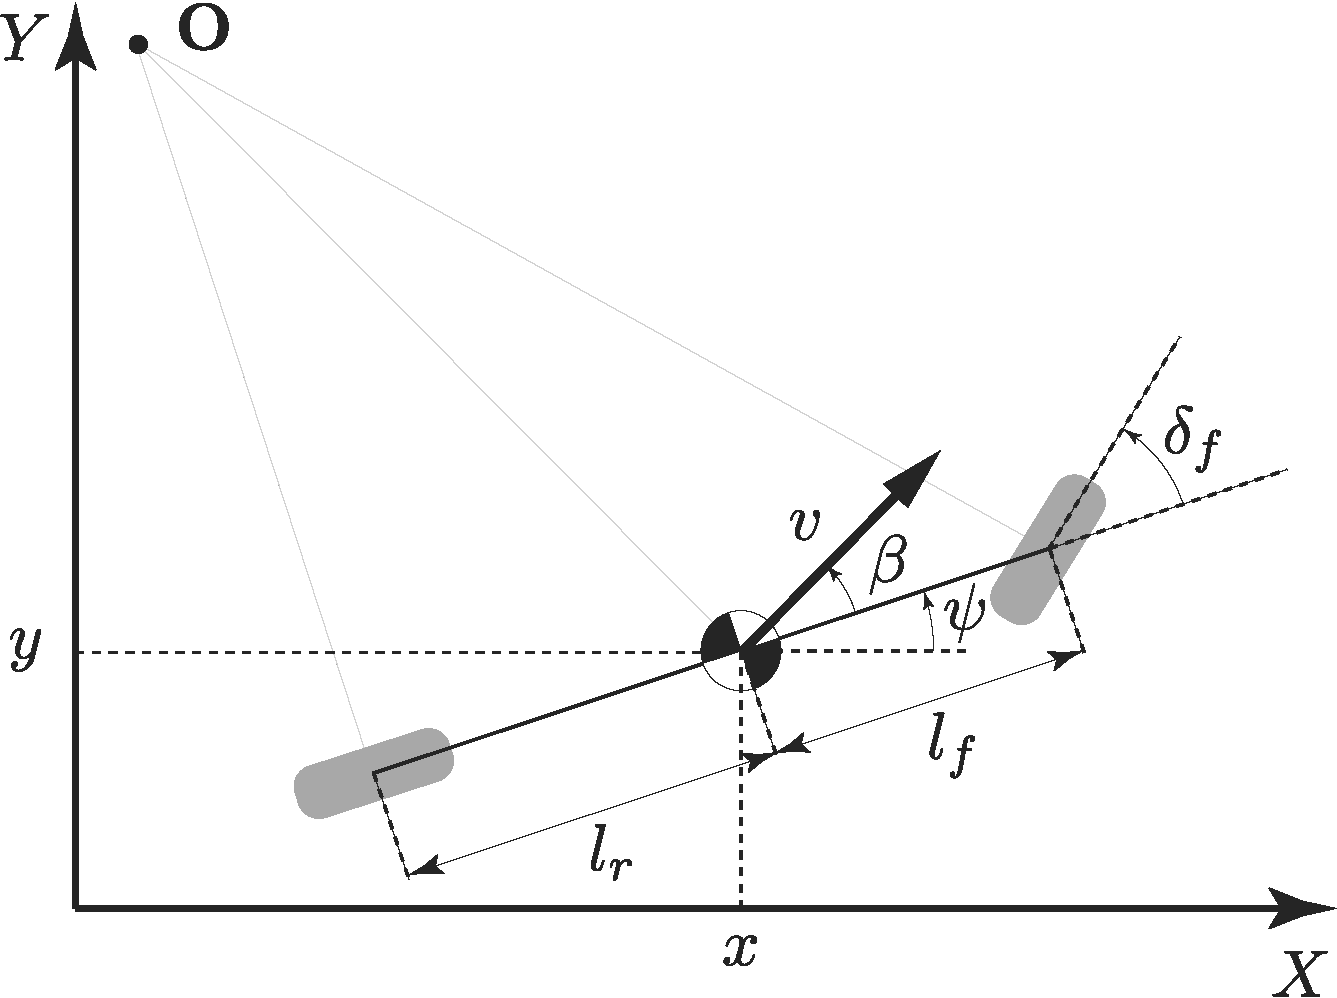 </center>

Consider a simplified kinematic bicycle model :

\begin{align}
\dot{x} &= v \cos(\psi+\beta)\\ 
\dot{y} &= v \sin(\psi+\beta)\\
\dot{\psi} &= \frac{v}{l_r} \sin(\beta)\\
\dot{v} &= a \\
\beta &= \tan^{-1} \left( \frac{l_r}{l_f+l_r}  \tan(\delta_f)\right)
\end{align}

If assume {\delta_f}, {\psi} and {\beta} are small, we can approximize the system as below : 

\begin{align}
\dot{x} &= v \\ 
\dot{y} &= v{\psi} + \frac{l_r}{l_f+l_r}v{\delta_f} \\
\dot{\psi} &= \frac{1}{l_f+l_r}v{\delta_f} \\
\dot{v} &= a \\
\end{align}

Reference : https://ieeexplore.ieee.org/document/8734145/ - Trajectory Planning for Autonomous High-Speed Overtaking in Structured Environments Using Robust MPC

In [ ]:
# Car model

#---------------- Parameters ---------------#
### Road Geometry #####
lane_width = 3.5 # [m]
num_lane = 2

### SV (Subject Vehicle) parameter ###
l_f = 1.446 # [m]
l_r = 1.477 # [m]
SV_v_desired = 32.67 # [m/s]


SV_initial_x = 0 # [m]
SV_initial_y = lane_width/2*3 # [m]
SV_initial_psi = 0
SV_initial_v = SV_v_desired # [m/s]

### LV (Lead Vehicle) parameter ###
# Assume they don't change their lane and run in a constant velocity
num_LV = 3
LV_l_long = 4.1
LV_w_lat = 1.7
wedge_back = 40 # modified 1
wedge_head = 40 # modified 100

# LV_information 
## For showing cacenlling lane change : SV_initial_x - 93.5, vel = 45 for the second LV
# LV_initialize  = np.array([[SV_initial_x + 80, SV_initial_x + 80, SV_initial_x + 240],  # x coordinate [m] # modified. 110 220 330. Threshold : 80
#                            [lane_width/2, lane_width/2*3, lane_width/2],       # y coordinate [m]
#                            [22.5, 22.5, 22.5]])                                           # velocity [m/s]

# # Default MPC Cost Matrix Setting
# P = np.eye(4)
# Q = np.diag([0.0, 0.2, 0.01, 10])
# R = np.diag([1.5, 200]) 
# Af = np.array([[1.0,0], [-1.0,0], [0,1.0], [0,-1.0]])
# bf = np.array([0.0, 0.0, 0.0, 0.0])

### Potential Field ###
A_car = 10
Xi = 3
A_lane = 36
sigma = 0.14 * lane_width
alpha = 0.16
Vertice = [[100, 0], [100, num_lane*lane_width], [-60, num_lane*lane_width], [-60, 0]]
U_safe = 10
grid_length = 0.01

### System Parameters ###
# SV_x has no limit
SV_y_lower = 0 # lower limit of y
SV_y_upper = num_lane*lane_width
SV_psi_lower = -0.05
SV_psi_upper = 0.05
SV_v_lower = 0
SV_v_upper = 35

SV_a_upper = 2.0 # [m/s^2]
SV_a_lower = -5.0
SV_delta_upper = 0.03 # [rad]
SV_delta_lower = -0.03

X_set = pt.Polytope(np.array([[1.0, 0, 0, 0],
                              [-1.0, 0, 0, 0],
                              [0, 1.0, 0, 0],
                               [0, -1.0, 0, 0],
                               [0, 0, 1.0, 0],
                               [0, 0, -1.0, 0],
                               [0, 0, 0, 1.0],
                               [0, 0, 0, -1.0]]), 
                    np.array([[np.Inf],
                              [np.Inf],
                              [SV_y_upper],
                            [-SV_y_lower],
                            [SV_psi_upper],
                            [-SV_psi_lower],
                            [SV_v_upper],
                            [-SV_v_lower]]))

U_set = pt.Polytope(np.array([[1.0, 0],
                              [-1.0, 0],
                              [0, 1.0],
                              [0, -1.0]]), 
                    np.array([[SV_a_upper],
                              [-SV_a_lower],
                              [SV_delta_upper],
                              [-SV_delta_lower]]))

print(X_set)

### Driving mode ###
FOLLOW_MODE = 0;
OVERTAKE_MODE = 1;


Single polytope 
  [[ 1.  0.  0.  0.] |    [[  inf]
   [-1.  0.  0.  0.] |     [  inf]
   [ 0.  1.  0.  0.] |     [ 7.  ]
   [ 0. -1.  0.  0.] x <=  [ 0.  ]
   [ 0.  0.  1.  0.] |     [ 0.05]
   [ 0.  0. -1.  0.] |     [ 0.05]
   [ 0.  0.  0.  1.] |     [35.  ]
   [ 0.  0.  0. -1.]]|     [ 0.  ]]



# Class and Functions

Class - Class for vehicles (My vehicle := Subject Vehicle, Obstacle vehicle := Leading vehicle)

Functions - Functions needed for the project, including calculating reachable set, risk map, target point, etc



In [ ]:
class Subject_vehicle :
  def __init__(self, init_x, init_y, init_psi, l_f = l_f, l_r = l_r, length = LV_l_long, width = LV_w_lat, init_vel = SV_initial_v, drive_mode = OVERTAKE_MODE, sampling_time = 0.2) :
    self.l_f = l_f
    self.l_r = l_r
    self.state = np.array([init_x, init_y, init_psi, init_vel])
    self.length = length
    self.width = width
    self.A = np.array([[1.0, 0, 0, sampling_time],
                       [0, 1.0, self.state[3]*sampling_time, 0],
                       [0, 0, 1.0, 0],
                       [0, 0, 0, 1]])
    self.B = np.array([[0, 0],
                       [0, self.state[3]*sampling_time / (self.l_f+self.l_r) * self.l_r],
                       [0, self.state[3]*sampling_time / (self.l_f+self.l_r)],
                       [sampling_time, 0]])
    self.lane_thresh = 0.05    # if SV stays 0.8m away from the head_lane, we suppose it successfully changed the lane.
    
    for i in range(num_lane) :
      if self.state[1] > i*lane_width and self.state[1] <= (i+1)*lane_width :
        self.curr_lane = num_lane - i
        self.head_lane = self.curr_lane

    self.drive_mode = drive_mode
    self.LV_ahead = -1

  def getState(self) :
    return self.state

  def update_state_approx(self, input) :
    self.state = self.A @ self.state + self.B @ input
    self.set_curr_lane()

  def update_state_Notapprox(self, input) :
    beta = np.arctan( self.l_r / (self.l_f + self.l_r) * np.tan(input[1]))
    self.state += sampling_time * np.array([self.state[3] * np.cos(beta + self.state[2]),
                                            self.state[3] * np.sin(beta + self.state[2]),
                                            self.state[3]/self.l_r*np.sin(beta),
                                            input[0]])
    self.set_curr_lane()
  
  def getLaneInfo(self) :
    return [self.curr_lane, self.head_lane]

  def getDriveMode(self) :
    return self.drive_mode

  def getLVAhead(self) :
    return self.LV_ahead
  
  def set_curr_lane(self) :
    head_lane_y = lane_width/2 + lane_width*(num_lane - self.head_lane)
    if abs(head_lane_y - self.state[1]) < self.lane_thresh :
      self.curr_lane = self.head_lane

  def set_head_lane(self, target_point) :
    for i in range(num_lane) :
      if target_point[1] >= i*lane_width and target_point[1] < (i+1)*lane_width :
        self.head_lane = num_lane - i
        break

  def set_drive_mode(self, drive_mode) :
    self.drive_mode = drive_mode

  def set_LV_ahead(self, LV_idx) :
    self.LV_ahead = LV_idx
  


class Lead_vehicle :
  def __init__(self, init_x, init_y, vel, length = LV_l_long, width = LV_w_lat, _wedge_back = wedge_back, _wedge_head = wedge_head) :
    self.pos = np.array([init_x, init_y])
    self.length = length
    self.width = width
    self.vel = vel
    self.wedge_back = _wedge_back
    self.wedge_head = _wedge_head
    self.pos_pred = np.array([self.pos[0] + N*sampling_time*self.vel, self.pos[1]])

  def getVelocity(self) :
    return self.vel

  def setVelocity(self, vel) :
    self.vel = vel

  def getPosition(self) :
    return self.pos

  def getPosition_predict(self) :
    return self.pos_pred
  
  def updatePosition(self) :
    self.pos[0] += sampling_time * self.vel
    self.pos_pred[0] = self.pos[0] + N*sampling_time*self.vel

  def getWedgePoints(self) :
    return np.array([[self.pos[0] - self.length/2 - self.wedge_back, self.pos[1]],
                     [self.pos[0] - self.length/2, self.pos[1] + self.width/2],
                     [self.pos[0] + self.length/2, self.pos[1] + self.width/2],
                     [self.pos[0] + self.length/2 + self.wedge_head, self.pos[1]],
                     [self.pos[0] + self.length/2, self.pos[1] - self.width/2],
                     [self.pos[0] - self.length/2, self.pos[1] - self.width/2]])
    
  def getWedgePoints_predict(self) :
    current_WedgePoints = self.getWedgePoints()
    current_WedgePoints[:,0] += N*sampling_time*self.vel
    return current_WedgePoints
  
  def makePolytope(self, vertices) :
    A = np.empty((6,2))
    B = np.empty((6,1))
    idx = 0
    for i in [1,3,4,0] :
      x1, y1, x2, y2 = [vertices[i,0], vertices[i,1], vertices[i-1,0], vertices[i-1,1]]
      a = (y2-y1)/(x2-x1)
      b = y1 - a*x1
      if i in [1,3] :
        A[idx,:] = [-a, 1.0]
        B[idx,:] = [b]
      else :
        A[idx,:] = [a, -1.0]
        B[idx,:] = [-b]
      idx += 1
    A[4:,:] = [[0, 1.0], [0, -1.0]]
    B[4:,:] = [[self.width/2 + self.pos[1]], [self.width/2 - self.pos[1]]]

    return pt.Polytope(A, B)

  def getPolytope(self) :
    vertices = self.getWedgePoints()
    return self.makePolytope(vertices)

  def getPolytope_predict(self) :
    vertices = self.getWedgePoints_predict()
    return self.makePolytope(vertices)

  ###### For Animation ###############
  def getVertice_anim(self, position) :
    vertice_x = np.array([[position[0] + self.length/2, position[0] - self.length/2, position[0] - self.length/2, position[0] + self.length/2]])
    vertice_y = np.array([[position[1] + self.width/2,  position[1] + self.width/2,  position[1] - self.width/2,  position[1] - self.width/2]])
    vertice = np.concatenate((vertice_x.T, vertice_y.T), axis=1)
    return vertice

  def getWedgePoints_anim(self, position) :
    WedgePoints = np.array([[position[0] - self.length/2 - self.wedge_back, position[1]],
                            [position[0] - self.length/2, position[1] + self.width/2],
                            [position[0] + self.length/2, position[1] + self.width/2],
                            [position[0] + self.length/2 + self.wedge_head, position[1]],
                            [position[0] + self.length/2, position[1] - self.width/2],
                            [position[0] - self.length/2, position[1] - self.width/2]])
    return WedgePoints

# SV = Subject_vehicle(init_x = SV_initial_x, init_y = SV_initial_y, init_psi = SV_initial_psi)
# LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
# LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])
# print(LV1.getPosition())
# fig, ax = plt.subplots(1,2)
# X = LV1.getPolytope()
# X_pred = LV1.getPolytope_predict()
# X.plot(ax[0], color='b')
# X_pred.plot(ax[0], color='r')
# ax[0].autoscale_view()
# ax[0].set_zlim([-10,10])
# ax[0].axis('equal')


In [92]:
# Detect LVs
# Should detect LVs within 100m from SV
# Should know which LV is in front of SV or on the lane to which SV plans to move
def detect_LV(SV, LV_list) :
  x, v = SV.getState()[[0,3]]
  x_pred = x + v * sampling_time * N
  idx_front = -1
  idx_side_behind = -1
  idx_side_front = -1
  min_x_i = np.inf
  min_x_i_side = np.inf
  max_x_i_pred = -1

  
  for i in range(len(LV_list)) :
    lane_i = 0

    # get lane information of each LV
    [x_i, y_i] = LV_list[i].getPosition()
    for j in range(num_lane) :
      if y_i >= j*lane_width and y_i < (j+1)*lane_width :
        lane_i = num_lane - j
        break

    # Find out LV in front of SV
    if lane_i == SV.curr_lane :
      if x_i > x and x_i < min_x_i :
        min_x_i = x_i
        idx_front = i

    # Find out LV on the lane to which SV plans to move (All LVs whose predicted position is behind predicted position of SV)
    # In this case, since there are only 2 lanes, just 'else' is enough
    else :
      if x < x_i and x_i < min_x_i_side : 
        min_x_i_side = x_i
        idx_side_front = i

      x_i_pred = LV_list[i].getPosition_predict()[0]
      if x_pred > x_i_pred and x_i_pred > max_x_i_pred :
        max_x_i_pred = x_i_pred
        idx_side_behind = i
      
    
  return [idx_front, idx_side_behind, idx_side_front]
#-------------------------------------------------------------------------------#

# Reachability set - without accelerating
# with original system and ts=0.1, 20 step : 3m 17s
# with simple system and ts=0.2, 10 step : 1s (erasing acceleration term from the input vector)
# with simple system and ts=0.1, 20 step : 5s

def get_reachable_set(x0, y0, psi0, v0, ts, N, SV) :
  # set acceleration as (desired_vel - curr_vel) / Predict horizon
  # accel * sampling time is,
  a_ts = (SV_v_desired - SV.getState()[3]) / N
  X_tmp = np.array([0.0, 0.0, 0.0, a_ts])
  
  eps_pos = 0.01
  eps = 0.001
  A_sys = np.array([[1.0, 0, 0, ts],
                    [0, 1.0, v0*ts, 0],
                    [0, 0, 1.0, 0],
                    [0, 0, 0, 1.0]])
  '''
  B_sys = np.array([[0, 0],
                    [0, v0*l_r*ts/(l_f+l_r)],
                    [0, v0*ts/(l_f+l_r)],
                    [ts, 0]])
  '''
  B_sys = np.array([[0],
                    [v0*l_r*ts/(l_f+l_r)],
                    [v0*ts/(l_f+l_r)],
                    [0]])
  X = pt.Polytope(np.array([[1.0, 0, 0, 0], 
                            [-1.0, 0, 0, 0],
                            [0, 1.0, 0, 0],
                            [0, -1.0, 0, 0],
                            [0, 0, 1.0, 0],
                            [0, 0, -1.0, 0],
                            [0, 0, 0, 1.0],
                            [0, 0, 0, -1.0]]), 
                  np.array([[x0], 
                            [-x0+2*eps_pos],
                            [y0+eps_pos],
                            [-y0+eps_pos],
                            [psi0+eps],
                            [-psi0+eps],
                            [v0],
                            [-v0+2*eps]]))
  '''
  U = pt.Polytope(np.array([[1.0, 0], 
                            [-1.0, 0],
                            [0, 1.0],
                            [0, -1.0]]),
                  np.array([[0.0], 
                            [-SV_a_lower],
                            [SV_delta_upper],
                            [-SV_delta_lower]]))
  '''
  U = pt.Polytope(np.array([[1.0],
                            [-1.0]]),
                  np.array([[SV_delta_upper],
                            [-SV_delta_lower]]))
  
  for i in range(N) :
    # print(str(i) + 'th successor calculation')
    X = successor(X, A_sys, U, B_sys)
    X.b += X.A @ X_tmp
    X = X.intersect(X_set)
  return X

def get_point_in_2D_bbox(reachable_set, test = False) :
  pt_tmp = reachable_set.project([1,2])  # project the reachable set to x-y plane
  pt_tmp = pt_tmp.bounding_box           # pt_tmp = two corner of the bounding box of the projection : left_lower, right_upper
  x = np.arange(pt_tmp[0][0,0], pt_tmp[1][0,0], grid_length)
  
  threshold = 0.001
  if pt_tmp[0][1,0] < threshold :
    pt_tmp[0][1,0] += grid_length
  if pt_tmp[1][1,0] > num_lane*lane_width - threshold :
    pt_tmp[1][1,0] -= grid_length
    
  y = np.arange(pt_tmp[0][1,0], pt_tmp[1][1,0], grid_length)

  # Only for test - return points on large area
  if test :
    x = np.linspace(40, 70, 100)
    y = np.linspace(grid_length, num_lane*lane_width-grid_length, 100)
  ########
  
  xx, yy = np.meshgrid(x, y)
  return xx, yy

##### Potential Funtions - road potential, lane potential, car potential #####

# road potential - a potential function that prevents SV from getting closer to edges of the road
def road_potential(target) :
  road_risk = 0.5*Xi*((1/(target[1]-num_lane*lane_width))**2 + (1/target[1])**2)
  return road_risk

# lane potential - a potential function that forces SV to stay in the middle of the road
def lane_potential(target) :
  lane_risk = 0
  for i in range(num_lane+1) : 
    lane_risk += A_lane * np.exp( -(target[1]-i*lane_width)**2 / (2*(sigma**2)) )
  return lane_risk

# car_potential - a potential function that make SV stay away from LVs.
def car_potential(target, LV, turn_off) :
  if target in LV.getPolytope_predict() :  # modified LV.getPolytope()
    return np.Inf

  if turn_off :
    return 0
  point = LV.getWedgePoints_predict()     # modified LV.getWedgePoints()
  length = np.linalg.norm(target - point[0])
  for i in range(point.shape[0]-1) :
    tmp = np.linalg.norm(target - point[i+1])
    if length > tmp :
      length = tmp

  car_risk = A_car * (np.exp(-alpha*length)) / length 
  return car_risk

# Get risk value based on potential functions. If the return value is lower than U_safe, it's safe
def risk_value(target, _LV1, _LV2=None, _LV3=None, car_potential_off = True) :
  if _LV2 == None :
    return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off)
  if _LV3 == None :
    return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off) + car_potential(target, _LV2, car_potential_off)
  return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off) + car_potential(target, _LV2, car_potential_off) + car_potential(target, _LV3, car_potential_off)
#----------------------------------------------------------------------------#

# Among the points in reachable set, choose a target point using the risk map
def get_target_state(risk_map, SV, initial_x, LV_info, LV_list, print_safe_map = False, N=15) :
  x_tmp = risk_map[0,0]
  safe_map = risk_map[:, risk_map[2,:] < U_safe]             # filter the points in risk map that pass safe standard
  
  # get drive_mode from the decision layer
  [drive_mode, LV_idx] = Drive_mode_decision(safe_map, SV, LV_info, LV_list, x_tmp)
  
  if drive_mode == FOLLOW_MODE :
    SV.set_drive_mode(FOLLOW_MODE)                                              # Set follow mode
    SV.set_LV_ahead(LV_idx)
    if SV.getLaneInfo()[0] == SV.getLaneInfo()[1] :
      [target_x, target_y] = LV_list[LV_info[0]].getWedgePoints_predict()[0,:]
      target_x -= 3
      target_vel = LV_list[LV_info[0]].getVelocity()
      target_psi = 0.0
      target_state = np.array([target_x, target_y, target_psi, target_vel, 0])  # set the target point as the first point of wedgepoints of LV in front of SV
      target_acc = 2*(target_x - SV.getState()[0] - SV.getState()[3]*(sampling_time*N)) / ((sampling_time*N)**2)
    else :
      print('Follow ' + str(LV_idx) + 'th LV')
      [target_x, target_y] = LV_list[LV_idx].getWedgePoints_predict()[0,:]
      target_x -= 3
      target_vel = LV_list[LV_idx].getVelocity()
      target_psi = 0.0
      target_state = np.array([target_x, target_y, target_psi, target_vel, 0])  # set the target point as the first point of wedgepoints of LV in front of SV
      target_acc = 2*(target_x - SV.getState()[0] - SV.getState()[3]*(sampling_time*N)) / ((sampling_time*N)**2)
    SV.set_head_lane(target_state[:2])
    print(target_acc)
    return [target_state, target_acc]

  
  # Else, it is overtake mode
  SV.set_drive_mode(OVERTAKE_MODE)
  
  # obtain the farthest safe points in x-direction, which are on the same lane as SV if it's possible
  safe_map = safe_map[:, safe_map[0,:] == np.amax(safe_map[0,:])]           

  # If there are points on the same lane as SV's current lane, set safe_map as the set of those points
  tmp = safe_map[:, (safe_map[1,:] > (num_lane - SV.getLaneInfo()[0]) * lane_width) & (safe_map[1,:] < (num_lane - SV.getLaneInfo()[0] + 1) * lane_width)]
  if np.size(tmp,1) is not 0 : 
    safe_map = tmp

  if print_safe_map :
    print('Safe map with the biggest x')
    print(safe_map)

  lowest_risk_point = safe_map[:, np.argmin(safe_map[2,:])]   # choose the safest point among the farthest safe points 
  target_vel = (lowest_risk_point[0] - initial_x) / (sampling_time*N)
  target_psi = 0.0
  target_state = np.array([lowest_risk_point[0], lowest_risk_point[1], target_psi, target_vel, lowest_risk_point[2]])
  # print(target_state)
  SV.set_head_lane(target_state[:2])
  
  return [target_state, 0.0]

def Drive_mode_decision(safe_map, SV, LV_info, LV_list, target_x_tmp) :
  # # The case that triggers follow mode : when there is no safe point
  # if np.size(safe_map,1) == 0 :
  #   return FOLLOW_MODE

  # # The case that triggers overtake mode from follow mode
  # if SV.getDriveMode() == FOLLOW_MODE :
  #   # when there's no car ahead of SV on the other lane, or the car is far enough from SV to safely change the lane
  #   if LV_info[2] == -1 or LV_list[LV_info[2]].getPosition()[0] > np.amax(safe_map[0,:]) :
  #     return OVERTAKE_MODE
  #   else  :
  #     return FOLLOW_MODE

  # # else cases : maintain overtake mode  
  # return OVERTAKE_MODE
  if np.size(safe_map,1) == 0 :
    follow_LV_idx = -1
    if LV_info[1] == -1 :
      follow_LV_idx = LV_info[2]
    elif LV_info[2] == -1 :
      follow_LV_idx = LV_info[0]
    elif target_x_tmp - LV_list[LV_info[1]].getPosition_predict()[0] < LV_list[LV_info[2]].getPosition_predict()[0] - target_x_tmp :
      follow_LV_idx = LV_info[0]
    else :
      follow_LV_idx = LV_info[2]
    return [FOLLOW_MODE, follow_LV_idx]

  # When np.size(safe_map,1) != 0
  if SV.getDriveMode() == FOLLOW_MODE :
    print('debug msg1')
    # obtain the farthest safe points in x-direction, which are on the same lane as SV if it's possible
    safe_map = safe_map[:, safe_map[0,:] == np.amax(safe_map[0,:])]           

    tmp = safe_map[:, (safe_map[1,:] > (num_lane - SV.getLaneInfo()[1]) * lane_width) & (safe_map[1,:] < (num_lane - SV.getLaneInfo()[1] + 1) * lane_width)]
    if np.size(tmp,1) == np.size(safe_map,1) and tmp[0,0] > LV_list[SV.getLVAhead()].getWedgePoints_predict()[0,0] :
      print('Safe point exist, but maintain follow mode')
      return [FOLLOW_MODE, SV.getLVAhead()]
  
  return [OVERTAKE_MODE, -1]
  #---------------------------------------------------------------------------#


In [ ]:
def test(t) :
  t = t[:3]
  return 

test_ = np.array([1,2,3,4,5,6,7])
print(test_)
test(test_)
print(test_)

[1 2 3 4 5 6 7]
[1 2 3 4 5 6 7]


# Test Cell

In [93]:
#### test ####
'''
test = get_reachable_set(SV_initial_x, SV_initial_y, 0.03, SV_initial_v, 0.2, 10)
get_point_in_2D_bbox(test)
X = test.project([1,2])
print(X)

fig, ax = plt.subplots(1,2)
X.plot(ax[0], color='b')
ax[0].legend(['X', 'X & Pre(X, W)'])
ax[0].autoscale_view()
ax[0].axis('equal')


X = X.bounding_box
print(X)
print(X[0][1,0])
for a,b in X :
  print("corner : x : " + str(a[0]) + " y : " + str(b[0]))
  '''
##########
# 6.666  ]
#  [ 1.75     1.79245]
#  [ 0.       0.02874]
#  [33.33    33.48603
SV = Subject_vehicle(init_x = SV_initial_x, init_y = SV_initial_y, init_psi = SV_initial_psi)
LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])

U_safe = np.Inf
xx, yy = get_point_in_2D_bbox(get_reachable_set(SV.getState()[0], SV.getState()[1], SV.getState()[2], SV.getState()[3], 0.2, 10), False)
risk_map = np.zeros((3,xx.size))
index = 0
for i in range(xx.shape[0]) :
  for j in range(xx.shape[1]) :
    risk_map[0,index] = xx[i,j]
    risk_map[1,index] = yy[i,j]
    risk_map[2,index] = risk_value(np.array([xx[i,j], yy[i,j]]), LV1)
    index += 1

test_target_point = get_target_state(risk_map, SV.getState()[0])
risk_map = risk_map[:, risk_map[2,:]<U_safe]

ax = plt.axes(projection='3d')
ax.scatter3D(risk_map[0,:], risk_map[1,:], risk_map[2,:], alpha = 0.1, c = risk_map[0,:] + risk_map[1,:] +risk_map[2,:], cmap = plt.get_cmap('hsv'))
ax.scatter3D(test_target_point[0], test_target_point[1], test_target_point[4])
ax.set_zlim(0, 150);
print('SV state : ')
print(SV.getState())
print('LV position - LV1 : ')
print(LV1.getPosition())
print('LV2 : ')
print(LV2.getPosition())
print(test_target_point)


TypeError: ignored

# Design MPC

In [103]:
# Solve CFTOC for car
from __future__ import division

def solve_cftoc_onlyCar(A, B, P, Q, R, N, x0, X_set, U_set, a, bf, Af, SV, LV_info, LV_list, add_extra_constraint, reachable_set = None) :
  model = pyo.ConcreteModel()
  model.A = A
  model.B = B
  model.P = P
  model.Q = Q
  model.R = R
  model.N = N
  model.Af = Af
  model.SV = SV
  model.LV_front = LV_list[LV_info[0]]  if LV_info[0] != -1 else None
  model.LV_side = LV_list[LV_info[1]]   if LV_info[1] != -1 else None
  model.X_set = X_set
  model.U_set = U_set
  
  model.nx = np.size(A,1)
  model.nu = np.size(B,1)

  model.tidx = pyo.Set(initialize = range(0,N+1))
  model.xidx = pyo.Set(initialize = range(0, model.nx))
  model.uidx = pyo.Set(initialize = range(0, model.nu))

  model.x = pyo.Var(model.xidx, model.tidx)
  model.u = pyo.Var(model.uidx, model.tidx)
  model.target_state = bf
  model.target_acc = a
  model.strict_terminalConst = True

  # test
  model.target_state_stage = model.target_state
  model.target_state_stage[2] = (model.target_state[1] - x0[1])/(model.target_state[0] - x0[0])

  eps = 0.001

  def Objective_func_rule(model) :
    costP = 0
    costQ = 0
    costR = 0

    for t in model.tidx :
      for i in model.xidx :
        if t < model.N :
          costQ += (model.x[i,t] - model.target_state[i]) * model.Q[i,i] * (model.x[i,t] - model.target_state[i])

    for t in model.tidx :
      for i in model.uidx :
        if t < model.N :
          if SV.getDriveMode() == OVERTAKE_MODE :
            costR += (model.u[i,t] - model.target_acc) * model.R[i,i] * (model.u[i,t] - model.target_acc)
          else :
            model.target_u = np.array([(model.target_state[3] - SV.getState()[3])/(model.N*sampling_time), 0])
            # print('follow mode')
            # print(model.target_state[0] - SV.getState()[0])
            # print(model.target_u)
            costR += (model.u[i,t] - model.target_u[i]) * model.R[i,i] * (model.u[i,t] - model.target_u[i])
    
    for i in model.xidx :
      for j in model.xidx :
        costP += (model.x[i,model.N] - model.target_state[i]) * model.P[i,j] * (model.x[j,model.N] - model.target_state[i])

    return costP + costQ + costR

  model.cost = pyo.Objective(rule = Objective_func_rule, sense = pyo.minimize)

  def Equality_constraint_rule(model, i, t) :
    return (sum(model.A[i,j] * model.x[j,t] for j in model.xidx) + sum(model.B[i,j] * model.u[j,t] for j in model.uidx)) - model.x[i,t+1] == 0 if t<model.N else pyo.Constraint.Skip

  def Initial_constraint_rule(model, i) :
    return model.x[i,0] - x0[i] == 0

  # When Af == [] & bf != [], x_terminal_value == x_target and y_terminal_value == y_target. This constraint may be modified 
  def Terminal_constraint_rule(model, i) :
    # print(model.Af)
    # print(model.target_state)
    if model.Af == [] :
      if model.target_state == [] :
        return pyo.Constraint.Skip
      else :
        model.strict_terminalConst = True
        if SV.getDriveMode() == OVERTAKE_MODE :
          print('Overtake mode - strict terminal constraint')
          return model.x[i,N] - model.target_state[i] == 0 if i<2 else pyo.Constraint.Skip   # This may be modified
        elif SV.getDriveMode() == FOLLOW_MODE :
          print('follow mode - strict terminal constraint')
          return model.x[i,N] - model.target_state[i] == 0
    else :
      # When the terminal constraint is like target_x-eps <= x <= target_x+eps, target_y-eps <= y <= target_y+eps, ...
      model.strict_terminalConst = False
      if np.size(model.Af, 1) == 2 :
        # [x_eps, y_eps, psi_eps, v_eps] = [0.1, 0.1, 0.01, 0.01]
        # model.target_state = np.array([bf[0] + x_eps, -bf[0] + x_eps, bf[1] + y_eps, -bf[1] + y_eps, 
        #                                bf[2] + psi_eps, -bf[2] + psi_eps, bf[3] + v_eps, -bf[3] + v_eps])
        [x_eps, y_eps] = [0.1, 0.1]
        model.target_state = np.array([bf[0] + x_eps, -bf[0] + x_eps, bf[1] + y_eps, -bf[1] + y_eps])
        return sum(model.Af[i,j] * model.x[j,N] for j in range(0,2)) - model.target_state[i] <= 0
      else :
        return sum(model.Af[i,j] * model.x[j,N] for j in range(0,2)) - model.target_state[i] <= 0

  def Inequality_constraint_rule_state(model, i, t) :
    return sum(model.X_set.A[i,j] * model.x[j,t] for j in model.xidx) - model.X_set.b[i] <= 0

  def Inequality_constraint_rule_input(model, i, t) :
    return sum(model.U_set.A[i,j] * model.u[j,t] for j in model.uidx) - model.U_set.b[i] <= 0

  model.equalityConst = pyo.Constraint(model.xidx, model.tidx, rule = Equality_constraint_rule)
  model.initConst = pyo.Constraint(model.xidx, rule = Initial_constraint_rule) 
  model.terminalConst = pyo.Constraint(model.xidx, rule = Terminal_constraint_rule)
  
  model.StateConst = pyo.Constraint(range(0, np.size(model.X_set.A, 0)), model.tidx, rule = Inequality_constraint_rule_state)
  model.InputConst = pyo.Constraint(range(0, np.size(model.U_set.A, 0)), model.tidx, rule = Inequality_constraint_rule_input)
  # model.StateConst1 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1,t] <= SV_y_upper )
  # model.StateConst2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[2,t] <= SV_psi_upper if t>0 else pyo.Constraint.Skip)
  # model.StateConst3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[3,t] <= SV_v_upper)
  # model.StateConst4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1,t] >= SV_y_lower)
  # model.StateConst5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[2,t] >= SV_psi_lower if t>0 else pyo.Constraint.Skip)
  # model.StateConst6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[3,t] >= SV_v_lower)
  

  # For debug
  [front_x1, front_y1, front_x2, front_y2, side_x1, side_y1, side_x2, side_y2] = [0,0,1,0,0,0,1,0]
  # When the heading line and the current line are different 
  if model.SV.getLaneInfo()[0] != model.SV.getLaneInfo()[1] and add_extra_constraint :
    print('Move from lane', model.SV.getLaneInfo()[0], 'to', model.SV.getLaneInfo()[1], '. LV info : ', LV_info[0], ' ', LV_info[1])
    # When SV heads to the second lane from the first lane
    if model.SV.getLaneInfo()[0] == 1 :
      if(model.LV_front != None) :
        [front_x1, front_y1] = model.LV_front.getWedgePoints()[0,:]
        [front_x2, front_y2] = model.LV_front.getWedgePoints()[5,:]
        
        def Inequality_extraConstraint_rule_state_front(model, t) :
          return model.x[1,t] - front_y1 - ((front_y2-front_y1)/(front_x2-front_x1))*(model.x[0,t] - front_x1) <= 0
        model.StateConst7 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_front)
     
      if(model.LV_side != None) :
        [side_x1, side_y1]   = model.LV_side.getWedgePoints()[2,:]
        [side_x2, side_y2]   = model.LV_side.getWedgePoints()[3,:]

        def Inequality_extraConstraint_rule_state_side(model, t) :
          return -model.x[1,t] + side_y1 + ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(model.x[0,t] - side_x1 ) <= 0
        model.StateConst8 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_side)
    
    # When SV heads to the first lane from the second lane
    else :
      if(model.LV_front != None) :
        [front_x1, front_y1] = model.LV_front.getWedgePoints()[0,:]
        [front_x2, front_y2] = model.LV_front.getWedgePoints()[1,:]

        def Inequality_extraConstraint_rule_state_front(model, t) :
          return -model.x[1,t] + front_y1 + ((front_y2-front_y1)/(front_x2-front_x1))*(model.x[0,t] - front_x1) <= 0
        model.StateConst7 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_front)

      if(model.LV_side != None) :
        print('bug check')
        [side_x1, side_y1]   = model.LV_side.getWedgePoints()[3,:]
        [side_x2, side_y2]   = model.LV_side.getWedgePoints()[4,:]

        def Inequality_extraConstraint_rule_state_side(model, t) :
          return model.x[1,t] - side_y1 - ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(model.x[0,t] - side_x1 ) <= 0
        model.StateConst8 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_side)
    

  # print(model.StateConst)
  # if model.SV.getLaneInfo()[0] == 2 and model.SV.getLaneInfo()[1] == 1 :
  #   model.display()
  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model)
  # results_write = results.write()

  it = 1
  while(results.solver.termination_condition != pyo.TerminationCondition.optimal and it<=5) :
    print('Emergency situation. Loose state constraints')
    model.X_set.b = np.array([[np.Inf],
                              [np.Inf],
                              [SV_y_upper],
                              [-SV_y_lower],
                              [SV_psi_upper * (3*it)],
                              [-SV_psi_lower * (3*it)],
                              [SV_v_upper],
                              [-SV_v_lower]])

    model.StateConst = pyo.Constraint(range(0, np.size(model.X_set.A, 0)), model.tidx, rule = Inequality_constraint_rule_state)
    results = solver.solve(model)
    it+=1

  if results.solver.termination_condition == pyo.TerminationCondition.optimal :
    feas = True
  else :
    feas = False
    model.display()
  
  xOpt = np.asarray([[pyo.value(model.x[i,t]) for t in model.tidx] for i in model.xidx])
  uOpt = np.asarray([[pyo.value(model.u[i,t]) for t in model.tidx if t<model.N] for i in model.uidx])
  JOpt = model.cost()

  wedge_LV1 = LV_list[0].getWedgePoints()
  wedge_LV1_predicted = LV_list[0].getWedgePoints_predict();
  wedge_LV2 = LV_list[1].getWedgePoints()
  wedge_LV2_predicted = LV_list[1].getWedgePoints_predict();
  wedge_LV3 = LV_list[2].getWedgePoints()
  wedge_LV3_predicted = LV_list[2].getWedgePoints_predict();

  fig, ax = plt.subplots(1,1,figsize=(9,6))
  # actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
  ax.plot(xOpt[0,:], xOpt[1,:], 'y*--', linewidth=1)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title('State Trajectory')
  ax.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV2[:,0], wedge_LV2[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV3[:,0], wedge_LV3[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV1_predicted[:,0], wedge_LV1_predicted[:,1], alpha = 0.2, c = 'r')
  ax.fill(wedge_LV2_predicted[:,0], wedge_LV2_predicted[:,1], alpha = 0.2, c = 'r')
  ax.fill(wedge_LV3_predicted[:,0], wedge_LV3_predicted[:,1], alpha = 0.2, c = 'r')

  if reachable_set is not None :
    reachable_set.plot(ax)
  plt.show()
  tmp_float = np.zeros((2, N+1))
  tmp_bool = np.zeros((2, N+1), dtype=bool)
  
  print('SV Lane Info : ', SV.getLaneInfo())
  print('LV info : ', LV_info)
  if model.SV.getLaneInfo()[0] != model.SV.getLaneInfo()[1] :
    for i in model.tidx :
      tmp_front = -xOpt[1,i] + front_y1 + ((front_y2-front_y1)/(front_x2-front_x1))*(xOpt[0,i] - front_x1)
      tmp_side = xOpt[1,i] - side_y1 - ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(xOpt[0,i] - side_x1 )
      tmp_float[0,i] = tmp_front
      tmp_float[1,i] = tmp_side
      tmp_bool[0,i] = tmp_front <= 0
      tmp_bool[1,i] = tmp_side <= 0

    print(tmp_float)
    print(tmp_bool)

  return [feas, xOpt, uOpt, JOpt]

In [ ]:
# MPC Cost Martix
def MPC_cost_matrix(target_state, SV) :  
  if SV.getDriveMode() == OVERTAKE_MODE :
    P = np.eye(4)
    Q = np.diag([0.0, 0.2, 0.01, 10]) # modified. [1,1] = 0.2
    R = np.diag([1.5, 200]) # modified 200
    Af = np.array([[1.0,0], [-1.0,0], [0,1.0], [0,-1.0]])
    bf = target_state[:4]
    return [P, Q, R, Af, bf]

  elif SV.getDriveMode() == FOLLOW_MODE :
    P = 50 * np.eye(4)
    P[3,3] = 150
    Q = np.diag([0.0, 0.01, 0.01, 0.0]) # modified. [1,1] = 0.2
    R = np.diag([250, 50]) # modified 200
    Af = np.array([[1.0,0], [-1.0,0], [0,1.0], [0,-1.0]])
    bf = target_state[:4]
    return [P, Q, R, Af, bf]

In [104]:
############ Initialize the system #################
U_safe = 0.6459
sampling_time = 0.2
N = 15
SV = Subject_vehicle(SV_initial_x, SV_initial_y, SV_initial_psi)
LV_initialize  = np.array([[SV_initial_x - 100, SV_initial_x + 52, SV_initial_x + 40],  # x coordinate [m] # modified. 110 220 330. Threshold : 80
                           [lane_width/2*3, lane_width/2*3, lane_width/2],       # y coordinate [m]
                           [27, 27, 30]])                                           # velocity [m/s]

LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])
LV3 = Lead_vehicle(LV_initialize[0,2], LV_initialize[1,2], LV_initialize[2,2])
LV_list = [LV1, LV2, LV3]
####################################################

x0 = SV.getState()
M = 40  # 165
feas = np.zeros((M), dtype=bool)
xOpt = np.zeros((np.size(SV.A,1), M+1))
xPred = np.zeros((4, N+1, M))
uPred = np.zeros((2, N, M))
LV1_pos = np.zeros((2, M+1))
LV2_pos = np.zeros((2, M+1))
LV3_pos = np.zeros((2, M+1))
LV1_pos_pred = np.zeros((2, M+1))
LV2_pos_pred = np.zeros((2, M+1))
LV3_pos_pred = np.zeros((2, M+1))
target_state_data = np.zeros((5, M))
target_state_pre = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

xOpt[:,0] = x0
LV1_pos[:,0] = LV1.getPosition()
LV2_pos[:,0] = LV2.getPosition()
LV3_pos[:,0] = LV3.getPosition()
LV1_pos_pred[:,0] = LV1.getPosition_predict()
LV2_pos_pred[:,0] = LV2.getPosition_predict()
LV3_pos_pred[:,0] = LV3.getPosition_predict()

uOpt = np.zeros((np.size(SV.B,1), M))
# predErr = np.zeros((2, M-N+1))
# xPred = np.zeros((2, N+1, M))

for t in range(M) :
  surround_LV_info = detect_LV(SV, LV_list)

  # Before getting target state, calculate reachable set and risk map
  # if it is follow mode, skip this step
  reachable_set = get_reachable_set(xOpt[0,t], xOpt[1,t], xOpt[2,t], xOpt[3,t], sampling_time, N, SV)

  tmp = pt.extreme(reachable_set)
  x_max = np.amax(tmp[:,0])
  x_min = np.amin(tmp[:,0])
  y_max = np.amax(tmp[:,1])
  y_min = np.amin(tmp[:,1])
  X = pt.box2poly([[x_min, x_max], [y_min, y_max]])
  xx, yy = get_point_in_2D_bbox(reachable_set)

  # Make risk map
  risk_map = np.zeros((3,xx.size))
  index = 0
  for i in range(xx.shape[0]) :
    for j in range(xx.shape[1]) :
      risk_map[0,index] = xx[i,j]
      risk_map[1,index] = yy[i,j]
      risk_map[2,index] = risk_value(np.array([xx[i,j], yy[i,j]]), LV1, LV2, LV3, True) # modified : car_potential_off = True
      index += 1
  # print(risk_map)

  # Get target point from the risk map. The output is [x_target, y_target, risk_value]
  [target_state, a] = get_target_state(risk_map, SV, xOpt[0,t], surround_LV_info, LV_list)
  print('risk value : ', target_state[4])
  print(target_state)
  # Change MPC Cost Matrix depends on SV.drive_mode
  [P, Q, R, Af, bf] = MPC_cost_matrix(target_state, SV)
  print(target_state)
  [fea, x, u, J] = solve_cftoc_onlyCar(SV.A, SV.B, P, Q, R, N, xOpt[:,t], X_set, U_set, a, bf, Af, SV, surround_LV_info, LV_list, True, X)
  print(target_state)
  if not fea :
    # xOpt = []
    # uOpt = []
    break
  print(t,'th step ended')
  feas[t] = True
  xPred[:,:,t] = x
  uPred[:,:,t] = u
  SV.update_state_Notapprox(u[:,0])  # modified update_state_approx
  print(target_state)

  # if SV.getLaneInfo()[1] == 2 :
  #   LV3.setVelocity(37)
  LV1.updatePosition()
  LV2.updatePosition()
  LV3.updatePosition()
  print(target_state)
  xOpt[:,t+1] = SV.getState()
  LV1_pos[:,t+1] = LV1.getPosition()
  LV2_pos[:,t+1] = LV2.getPosition()
  LV3_pos[:,t+1] = LV3.getPosition()
  print(target_state)
  LV1_pos_pred[:,t+1] = LV1.getPosition_predict()
  LV2_pos_pred[:,t+1] = LV2.getPosition_predict()
  LV3_pos_pred[:,t+1] = LV3.getPosition_predict()
  target_state_data[:,t] = target_state
  uOpt[:,t] = u[:,0]
  print(target_state)
  print(SV.getLVAhead())
  print('---------------------------------------------------------------------')

print('Feasiblilty : ',feas)
print(xOpt)
print(uOpt)

fig = plt.figure(figsize=(9,6))
actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
for t in range(np.size(xPred,2)) :
  pred = plt.plot(xPred[0,:,t], xPred[1,:,t], 'y*--', linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectory')
plt.show()


KeyboardInterrupt: ignored

In [ ]:
print(xOpt)
print(uOpt)
print(xPred)
print(uPred)
print(reachable_set.project([1,2]))
print(pt.extreme(reachable_set))

[[ 0.       6.534   13.0678  19.60147 26.13505 32.66856 39.202   45.73539
  52.26873 58.80204 65.33531 71.86811  0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.      

[1, 2]
[1, 2, -1]
[[ 98.004   104.53671 111.06946 117.60228 124.13517 130.66812 137.20111
  143.73413 150.26717 156.80023 163.3333  169.86594 176.39088 182.91582
  181.55    195.36244 201.92992 208.49226 215.04258 221.58805 228.13013
  234.67148 233.55    239.55    245.55    258.63512 257.55    263.55
  276.72245 275.55    281.55    294.76861 293.55    299.55    312.74015
  311.55    317.55    330.61744 329.55    342.84568 341.55    347.55
  360.64943 359.55    365.55    378.42543 377.55    383.55    396.20044
  402.76586 401.55    407.55    420.55781 419.55    432.73674 431.55
  437.55    450.50484 449.55    462.66977 461.55    467.55    480.4322
  479.55    492.59346 491.55    497.55    510.36163 509.55    522.52578
  521.55    534.70578 533.55    539.55    552.47878 551.55    564.64636
  563.55    576.80565 575.55    581.55    587.55    600.18215 599.55
  612.32925 618.90934 617.55    623.55    629.55    642.28785 648.85456
  647.55    653.55    659.55    672.22704 678.78561 677.55 

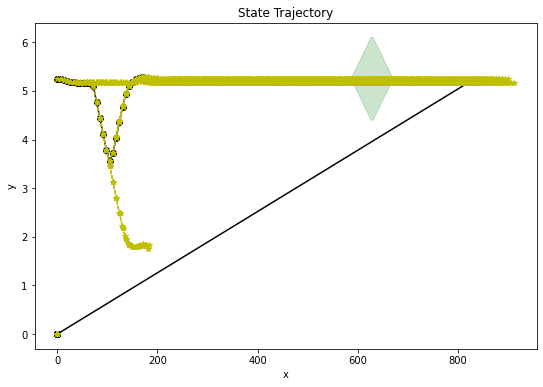

In [ ]:
print(SV.getLaneInfo())
print(detect_LV(SV, LV_list))
print(target_state_data)
wedge_LV1 = LV1.getWedgePoints()

fig = plt.figure(figsize=(9,6))
actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
for t in range(np.size(xPred,2)) :
  pred = plt.plot(xPred[0,:,t], xPred[1,:,t], 'y*--', linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectory')
plt.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')

plt.show()


(90.0, 243.99999999999994)

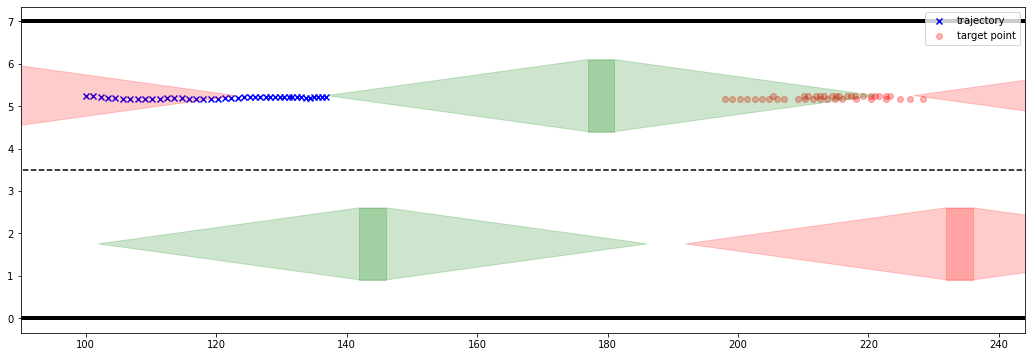

In [ ]:
# print(xOpt)
# print(LV1_pos)
# print(LV2_pos)
# print(target_point)
# print(xOpt[0,:])
# print(LV1_pos[0,:])
# print(xOpt[0,:] - LV1_pos[0,:])

wedge_LV1 = LV1.getWedgePoints()
vertice_LV1 = wedge_LV1[[1,2,4,5],:]
wedge_LV2 = LV2.getWedgePoints()
vertice_LV2 = wedge_LV2[[1,2,4,5],:]
wedge_LV3 = LV3.getWedgePoints()
vertice_LV3 = wedge_LV3[[1,2,4,5],:]

wedge_LV1[:,0] = wedge_LV1[:,0] - LV1.getPosition()[0]
vertice_LV1[:,0] = vertice_LV1[:,0] - LV1.getPosition()[0]
wedge_LV2[:,0] = wedge_LV2[:,0] - LV1.getPosition()[0]
vertice_LV2[:,0] = vertice_LV2[:,0] - LV1.getPosition()[0]
wedge_LV3[:,0] = wedge_LV3[:,0] - LV1.getPosition()[0]
vertice_LV3[:,0] = vertice_LV3[:,0] - LV1.getPosition()[0]

##---- Predicted location ----##
wedge_predict_LV1 = LV1.getWedgePoints_predict()
vertice_predict_LV1 = wedge_predict_LV1[[1,2,4,5],:]
wedge_predict_LV2 = LV2.getWedgePoints_predict()
vertice_predict_LV2 = wedge_predict_LV2[[1,2,4,5],:]
wedge_predict_LV3 = LV3.getWedgePoints_predict()
vertice_predict_LV3 = wedge_predict_LV3[[1,2,4,5],:]

wedge_predict_LV1[:,0] = wedge_predict_LV1[:,0] - LV1.getPosition()[0]
vertice_predict_LV1[:,0] = vertice_predict_LV1[:,0] - LV1.getPosition()[0]
wedge_predict_LV2[:,0] = wedge_predict_LV2[:,0] - LV1.getPosition()[0]
vertice_predict_LV2[:,0] = vertice_predict_LV2[:,0] - LV1.getPosition()[0]
wedge_predict_LV3[:,0] = wedge_predict_LV3[:,0] - LV1.getPosition()[0]
vertice_predict_LV3[:,0] = vertice_predict_LV3[:,0] - LV1.getPosition()[0]
################################

fig, ax = plt.subplots(1,1, figsize=(18,6))
ax.scatter(xOpt[0,:] - LV1_pos[0,:], xOpt[1,:],  marker ='x', c = 'b')
ax.scatter(target_state_data[0,:] - LV1_pos[0,:-1], target_state_data[1,:], alpha = 0.3, marker ='o', c = 'r')
ax.legend(['trajectory', 'target point'])

ax.plot([-1000, 1000], [lane_width, lane_width], '--', c = 'k')
ax.plot([-1000, 1000], [2*lane_width, 2*lane_width], linewidth = 4, c = 'k')
ax.plot([-1000, 1000], [0, 0], linewidth = 4, c = 'k')
ax.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV1[:,0], vertice_LV1[:,1], alpha = 0.2, c = 'g')
ax.fill(wedge_LV2[:,0], wedge_LV2[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV2[:,0], vertice_LV2[:,1], alpha = 0.2, c = 'g')
ax.fill(wedge_LV3[:,0], wedge_LV3[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV3[:,0], vertice_LV3[:,1], alpha = 0.2, c = 'g')

ax.fill(wedge_predict_LV1[:,0], wedge_predict_LV1[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV1[:,0], vertice_predict_LV1[:,1], alpha = 0.2, c = 'r')
ax.fill(wedge_predict_LV2[:,0], wedge_predict_LV2[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV2[:,0], vertice_predict_LV2[:,1], alpha = 0.2, c = 'r')
ax.fill(wedge_predict_LV3[:,0], wedge_predict_LV3[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV3[:,0], vertice_predict_LV3[:,1], alpha = 0.2, c = 'r')

ax.set_xlim([xOpt[0,0] - LV1_pos[0,0] - 10, LV3.getPosition()[0] - LV1.getPosition()[0] + 100])

[[-2.63842 -2.56976 -2.47474 -2.35926 -2.22853 -2.08706 -1.93878 -1.78706
  -1.63471 -1.48411 -1.33718  2.      -0.65159 -0.42242 -0.22557 -0.05886
   0.08034  0.19465  0.2866   0.35866  0.41314  0.45218  0.4487   0.4289
   0.43742  0.44412  0.44281  0.43501  0.42203  0.40499  0.38485  0.36245
   0.3385   0.31361  0.28832  0.26307  0.23822  0.21408  0.19088  0.1688 ]
 [-0.      -0.      -0.       0.       0.       0.       0.       0.
   0.       0.       0.      -0.02237 -0.00308 -0.00039 -0.00005 -0.00001
  -0.      -0.       0.       0.       0.00084  0.00331  0.00434  0.00443
   0.00397  0.00325  0.00245  0.00171  0.00109  0.00061  0.00027  0.00004
  -0.00009 -0.00016 -0.00017 -0.00016 -0.00013 -0.0001  -0.00007 -0.00005]]


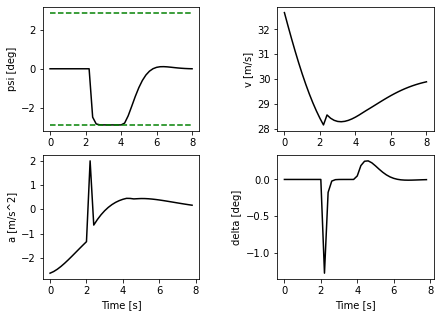

In [100]:
rad2deg = 180/np.pi
time = np.arange(0, M+1,1) * 0.2
fig, ax = plt.subplots(2,2, figsize = (7,5))
ax[0,0].plot(time, rad2deg * xOpt[2,:], 'k')
ax[0,0].plot(time, rad2deg * SV_psi_upper * np.ones(np.size(xOpt,1),), 'g--')
ax[0,0].plot(time, rad2deg * SV_psi_lower * np.ones(np.size(xOpt,1),), 'g--')
ax[0,1].plot(time, xOpt[3,:], 'k')
ax[1,0].plot(time[0:-1], uOpt[0,:], 'k')
ax[1,1].plot(time[0:-1], rad2deg * uOpt[1,:],'k')
fig.subplots_adjust(wspace=0.5)
ax[0,0].set_ylabel('psi [deg]')
ax[0,1].set_ylabel('v [m/s]')
ax[1,0].set_ylabel('a [m/s^2]')
ax[1,1].set_ylabel('delta [deg]')
ax[1,0].set_xlabel('Time [s]')
ax[1,1].set_xlabel('Time [s]')

print(uOpt)
# i = 8
# print(uPred[:,:,i])
# print(xPred[:,:,i])
# print(target_state_data[:,i])
# print(np.sum(uPred[:,:,i]) * 0.2)



# fig, ax = plt.subplots(2,2, figsize = (7,5))
# ax[0].plot()

# SV_psi_lower = -0.035
# SV_psi_upper = 0.035
# SV_v_lower = 22.5
# SV_v_upper = SV_v_desired

# SV_a_upper = 1.5 # [m/s^2]
# SV_a_lower = -1.5
# SV_delta_upper = 0.02 # [rad]
# SV_delta_lower = -0.02
# print(xOpt[:,44] in X_set) 

# Animation Maker:

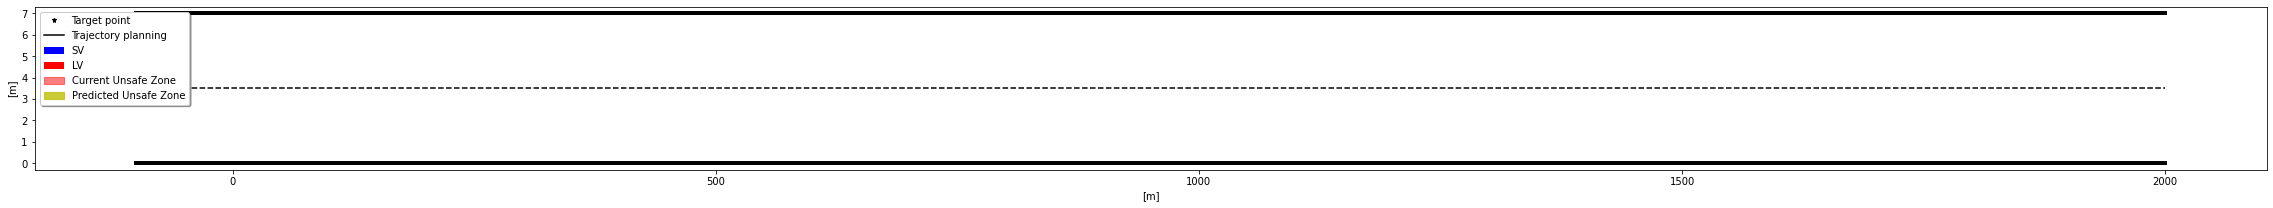

In [ ]:
################## ANIMATION #####################
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(40,3))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
# ax1.set_xlim(( 0, 2))            
ax1.set_ylim((-0.3, num_lane*lane_width+0.3))
ax1.set_xlabel('[m]')
ax1.set_ylabel('[m]')

ax1.plot([-100, 2000], [lane_width, lane_width], '--', c = 'k')
ax1.plot([-100, 2000], [2*lane_width, 2*lane_width], linewidth = 4, c = 'k')
ax1.plot([-100, 2000], [0, 0], linewidth = 4, c = 'k')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
target_pt, = ax1.plot([], [], 'k*', ms=5)
traj_pred, = ax1.plot([], [], 'k', )
SV_anim, = ax1.fill([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects

LV1_anim, = ax1.fill([], [], 'r')
LV1_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV1_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')


LV2_anim, = ax1.fill([], [], 'r')
LV2_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV2_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

LV3_anim, = ax1.fill([], [], 'r')
LV3_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV3_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

ax1.legend([target_pt, traj_pred, SV_anim, LV1_anim, LV1_unsafe_anim, LV1_pred_anim],['Target point','Trajectory planning', 'SV', 'LV', 'Current Unsafe Zone', 'Predicted Unsafe Zone'],
           loc='upper left', shadow=True);
# ax1.legend([target_pt, traj_pred, SV_anim, LV1_anim],['Target point','Trajectory planning', 'SV', 'LV'],
#            loc='upper left', shadow=True);

In [ ]:
'''
xOpt = np.zeros((np.size(SV.A,1), M+1))
xPred = np.zeros((3, N+1, M))
LV1_pos = np.zeros((2, M+1))
LV2_pos = np.zeros((2, M+1))
LV3_pos = np.zeros((2, M+1))
LV1_pos_pred = np.zeros((2, M+1))
LV2_pos_pred = np.zeros((2, M+1))
LV3_pos_pred = np.zeros((2, M+1))
target_point = np.zeros((3, M))
'''

def SV_draw(state) :
  l_f = SV.l_f
  l_r = SV.l_r
  car_width=1.7
  x = state[0]
  y = state[1]
  psi = state[2]
  SV_vertice_x = np.array([[x + l_f*np.cos(psi) - car_width/2*np.sin(psi),
                           x - l_r*np.cos(psi) - car_width/2*np.sin(psi),
                           x - l_r*np.cos(psi) + car_width/2*np.sin(psi),
                           x + l_f*np.cos(psi) + car_width/2*np.sin(psi)]])
  SV_vertice_y = np.array([[y + l_f*np.sin(psi) + car_width/2*np.cos(psi),
                           y - l_r*np.sin(psi) + car_width/2*np.cos(psi),
                           y - l_r*np.sin(psi) - car_width/2*np.cos(psi),
                           y + l_f*np.sin(psi) - car_width/2*np.cos(psi)]])
  SV_vertice = np.concatenate((SV_vertice_x.T, SV_vertice_y.T), axis=1)

  return SV_vertice

print(SV_draw(xOpt[:,10]))
def drawframe(n):
  ax1.set_xlim((xOpt[0,n]-20, xOpt[0,n]+120))
  target_pt.set_data(target_state_data[0,n], target_state_data[1,n])
  traj_pred.set_data(xPred[0,:,n], xPred[1,:,n]) 
  SV_anim.set_xy(SV_draw(xOpt[:,n]))

  LV1_anim.set_xy(LV1.getVertice_anim(LV1_pos[:,n]))
  LV1_unsafe_anim.set_xy(LV1.getWedgePoints_anim(LV1_pos[:,n]))
  LV1_pred_anim.set_xy(LV1.getWedgePoints_anim(LV1_pos_pred[:,n]))

  LV2_anim.set_xy(LV2.getVertice_anim(LV2_pos[:,n]))
  LV2_unsafe_anim.set_xy(LV2.getWedgePoints_anim(LV2_pos[:,n]))
  LV2_pred_anim.set_xy(LV2.getWedgePoints_anim(LV2_pos_pred[:,n]))

  LV3_anim.set_xy(LV3.getVertice_anim(LV3_pos[:,n]))
  LV3_unsafe_anim.set_xy(LV3.getWedgePoints_anim(LV3_pos[:,n]))
  LV3_pred_anim.set_xy(LV3.getWedgePoints_anim(LV3_pos_pred[:,n]))

  txt_title.set_text('Time = {0:4f}s'.format(n*0.2))
  
  return (target_pt,traj_pred)

[[66.77995  6.02277]
 [63.85696  6.0181 ]
 [63.85967  4.3181 ]
 [66.78267  4.32277]]


In [ ]:
from matplotlib import animation
from IPython.display import HTML

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=M, interval=300, blit=True)

HTML(anim.to_html5_video())

In [ ]:
'''
How to improve the model :
## Problem1 : Setting target point right behind of the front LV seems not reasonable intuitively 
## Problem2 : Since the cftoc design doesn't consider the risk map, the actual trajectory of SV intrudes unsafe zone of LVs. 

Here's idea to solve :
1) Problem1 : When calcuate car_potential value, let's consider predicted LV's configuration after ts*N sec (rather than considering the LV's configuration of when it was observed)
2) Problem2 : When solve cftoc, add constraint about x and y not to intrude the unsafe region. - But how?
                                                                                    - Need two information : LV in front of SV (Front obstacle), LV on the lane that SV will move to (Side obstacle) 
                                                                                    - May need three scenario : 1) changes lane (there's only Front obstacle) 2) after cross the middle line of the road, goes to steady state 
                                                                                                                3) changes lane (there are Front and Side obstacles) - refer to situation below. LV1 - Side obstacle, LV2 - Front 
                                                                                    
                                                                                    ==============================================================
                                                                                                 \   SV       \LV2
                                                                                    --------------\------------\-----------------------------------
                                                                                                LV1\          * \
                                                                                    ==============================================================
                                                                                    
                                                                                    - For each situation, constraint on x and y will be different
                                                                                    - Because extra constraints are added, X_f would better be larger
                                                                                    - For further scenario, 'there's no point whose risk value < U_safe' will be interesting
'''

"\nHow to improve the model :\n## Problem1 : Setting target point right behind of the front LV seems not reasonable intuitively \n## Problem2 : Since the cftoc design doesn't consider the risk map, the actual trajectory of SV intrudes unsafe zone of LVs. \n\nHere's idea to solve :\n1) Problem1 : When calcuate car_potential value, let's consider predicted LV's configuration after ts*N sec (rather than considering the LV's configuration of when it was observed)\n2) Problem2 : When solve cftoc, add constraint about x and y not to intrude the unsafe region. - But how?\n                                                                                    - Need two information : LV in front of SV (Front obstacle), LV on the lane that SV will move to (Side obstacle) \n                                                                                    - May need three scenario : 1) changes lane (there's only Front obstacle) 2) after cross the middle line of the road, goes to steady state \n    